In [1]:
pip install fastparquet lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.6 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
import lightgbm as lgb

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Nov-2022/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

## Reading data-files
submission = pd.read_csv(file_content_stream_1)
df = pd.read_parquet('s3://analytics-data-science-competitions/Tabular-Playground-Series/Tabular-Playground-Nov-2022/preds_concat_gzip.parquet', engine = 'fastparquet')

In [3]:
preds_df = df.clip(0, 1) ## Notice that some of the model prediction files have negative likehookds and greater than 1 likelihoods
train = preds_df[preds_df['target'].notnull()]
test = preds_df[preds_df['target'].isnull()] 

In [4]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['target']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac = 1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data = False, silent = True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = log_loss(y, clf.predict(data[train_features]))
    
    return imp_df

In [5]:
# Seed the unexpected randomness of this world
np.random.seed(253)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=train, shuffle=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.270302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [6]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,0.7301891713.csv,98.469757,107,0.481366
1,0.6750726968.csv,95.595743,55,0.481366
2,0.7194704070.csv,44.631556,40,0.481366
3,0.7107007521.csv,32.283775,29,0.481366
4,0.6952032365.csv,21.002132,29,0.481366


In [7]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.143055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.134223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.297492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.123736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.219317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.178102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.134359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.130897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.170727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.156933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.191933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.245843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.102218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.107043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.164488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.262414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.197293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.295476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.207533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.255358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.357949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.156009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.168472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.275297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.118507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.205875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.136533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.264335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.157042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.196570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.243063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.114303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.142110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.225447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.108098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.342146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.146757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.155818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.284168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.154931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.148650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.245769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.305618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.119619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.298209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.149405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.128596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.328463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.286735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.193284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.528803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.146145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.163508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.151847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.345070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.155199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.122806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.209753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.120084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.176577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.354249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.175420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.244885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.117567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.135267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.154468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.250762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.788553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.346812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.202431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.411971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.174352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.424090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.280820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.425809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.151619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.234943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.192277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.196074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 10000, number of negative: 10000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.316656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261381
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 4998
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [8]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])
scores_df.to_csv('scores_df.csv', index = False)

# plt.figure(figsize=(16, 16))
# gs = gridspec.GridSpec(1, 2)
# # Plot Split importances
# ax = plt.subplot(gs[0, 0])
# sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# # Plot Gain importances
# ax = plt.subplot(gs[0, 1])
# sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
# plt.tight_layout()

# Lasso Feature Seleection

In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Nov-2022/sample_submission.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Nov-2022/train_labels.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
submission = pd.read_csv(file_content_stream_1)
y_true = pd.read_csv(file_content_stream_2)
df = pd.read_parquet('s3://analytics-data-science-competitions/Tabular-Playground-Series/Tabular-Playground-Nov-2022/preds_logit_concat_gzip.parquet', engine = 'fastparquet')

Matplotlib is building the font cache; this may take a moment.


KeyboardInterrupt: 

In [3]:
y_true.head()

,id,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


In [4]:
preds = pd.merge(df, y_true, on = 'id', how = 'left')
preds.head()

,id,0.7301891713.csv,0.6750726968.csv,0.7194704070.csv,0.7107007521.csv,0.6952032365.csv,0.7311830751.csv,0.6736005999.csv,0.7205109360.csv,0.7298116981.csv,0.6737624943.csv,0.7105097012.csv,0.7163693161.csv,0.7225567087.csv,0.6872126167.csv,0.7292947020.csv,0.6798503735.csv,0.7130672940.csv,0.6709092823.csv,0.7391105353.csv,0.6616334858.csv,0.6897190987.csv,0.6963558296.csv,0.7170726761.csv,0.7156669797.csv,0.6814483512.csv,0.7167410246.csv,0.6981892492.csv,0.7119194656.csv,0.6932545022.csv,0.6593521643.csv,0.6743157708.csv,0.7125579799.csv,0.7069356577.csv,0.6884713711.csv,0.6702128703.csv,0.6564147356.csv,0.6977737011.csv,0.6638768547.csv,0.7032756348.csv,0.6862982027.csv,0.6864219834.csv,0.7088904051.csv,0.7212180410.csv,0.7421980731.csv,0.6825341422.csv,0.6848737762.csv,0.7144978161.csv,0.6658856476.csv,0.7195078907.csv,...,0.6870791547.csv,0.6967096004.csv,0.7060967827.csv,0.7113625862.csv,0.6694947166.csv,0.6900693308.csv,0.7128591265.csv,0.6818718747.csv,0.6858034178.csv,0.7122377012.csv,0.7144335192.csv,0.7083170570.csv,0.7142499638.csv,0.7136242881.csv,0.6888742488.csv,0.7087145574.csv,0.6566530931.csv,0.7197358544.csv,0.7101817035.csv,0.7520219713.csv,0.7215952204.csv,0.6795805487.csv,0.7083706040.csv,0.6941218921.csv,0.6926641668.csv,0.6869857003.csv,0.7198785912.csv,0.7287761089.csv,0.7035686386.csv,0.7336496744.csv,0.6872533788.csv,0.7005346672.csv,0.7369069391.csv,0.7156537235.csv,0.7121002711.csv,0.7289228406.csv,0.7174789519.csv,0.7032181627.csv,0.6668147232.csv,0.7345858839.csv,0.7056743178.csv,0.6850481924.csv,0.7359858591.csv,0.7068431477.csv,0.7121179915.csv,0.6613117872.csv,0.6843637618.csv,0.6781392004.csv,0.7222809303.csv,label
0,0,0.913897,2.142608,1.502359,1.453620,1.336538,1.599475,1.236069,1.054479,1.131611,0.984009,1.171605,1.207453,1.400562,1.156730,1.655767,0.405465,1.194848,1.542418,1.921342,0.641228,1.025477,1.378848,1.257294,1.280277,1.467210,1.443668,1.391678,1.419787,1.054552,3.539317,0.983944,1.476214,1.234424,1.307563,2.385436,2.001724,1.257358,1.689581,1.290093,1.277571,1.269417,0.953358,0.838936,1.437067,1.378712,-0.090514,1.220395,2.258836,1.228620,...,1.172375,1.109329,1.245783,1.377996,1.435160,1.195812,1.595924,1.338426,1.170736,1.263989,0.925031,0.862942,1.198344,1.414648,1.305720,0.937820,0.674106,1.475712,1.064896,0.678348,1.330522,1.242018,1.256842,1.234825,1.252730,1.259111,1.237227,1.548106,1.496501,1.588877,1.322937,1.301587,1.143404,1.285821,1.362650,1.133906,1.368576,1.159616,2.507343,0.925301,1.451954,1.199074,1.364975,1.650185,1.184054,0.660613,1.385376,1.596353,1.544845,0.0
1,1,0.678169,0.576310,0.298877,0.301982,0.698756,1.131453,0.569003,0.426954,0.510710,0.430144,0.221108,0.264951,1.556663,1.082496,1.407428,1.152680,0.920520,0.907372,1.113602,0.179283,1.125816,0.637407,0.381426,0.376108,1.140530,0.507529,0.556460,0.232753,0.004920,0.810242,1.154435,0.464158,0.571005,0.498050,0.208698,0.693851,0.753772,0.798899,0.556192,0.626027,0.599505,0.451303,0.421232,1.578557,1.518368,0.012512,0.332251,0.617989,0.828814,...,0.323980,0.483191,0.284638,0.408454,0.674884,0.355031,0.396140,1.250862,0.718760,0.147479,0.554945,0.257595,0.372066,0.811467,0.535556,0.407907,0.046973,0.404249,0.377877,0.950909,0.288525,0.595133,0.411427,0.758979,0.378051,0.539336,0.649062,0.266136,0.484547,0.557583,0.529086,1.068429,0.249275,0.325167,0.454034,0.363870,0.201669,0.191891,0.913241,0.593457,0.576423,0.604565,0.851182,0.545539,0.652546,0.147133,0.615547,0.412286,0.128416,1.0
2,2,1.222971,1.493293,1.997012,1.580462,1.181609,1.527942,1.655077,1.549787,1.668255,1.272369,1.688099,1.579537,-0.373970,1.167650,1.493627,1.152680,1.961822,1.120913,1.743965,0.915126,1.470307,1.403919,1.821767,1.689505,1.227045,1.376995,1.348107,1.619013,0.584926,1.492138,1.441973,1.098612,1.537328,1.360002,1.502614,1.400423,1.176323,1.449841,1.581607,1.417900,1.377263,1.590156,1.667259,1.592731,1.206471,0.565491,1.875071,1.503783,1.565373,...,1.275068,1.503897,1.652910,1.629185,1.435720,1.459440,1.472051,1.205913,1.217617,

In [5]:
train = preds[preds['label'].notnull()]
train['label'] = train['label'].astype(int)

test = preds[preds['label'].isnull()] 

/tmp/ipykernel_10624/3277270779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = train['label'].astype(int)


In [6]:
train.describe()

,id,0.7301891713.csv,0.6750726968.csv,0.7194704070.csv,0.7107007521.csv,0.6952032365.csv,0.7311830751.csv,0.6736005999.csv,0.7205109360.csv,0.7298116981.csv,0.6737624943.csv,0.7105097012.csv,0.7163693161.csv,0.7225567087.csv,0.6872126167.csv,0.7292947020.csv,0.6798503735.csv,0.7130672940.csv,0.6709092823.csv,0.7391105353.csv,0.6616334858.csv,0.6897190987.csv,0.6963558296.csv,0.7170726761.csv,0.7156669797.csv,0.6814483512.csv,0.7167410246.csv,0.6981892492.csv,0.7119194656.csv,0.6932545022.csv,0.6593521643.csv,0.6743157708.csv,0.7125579799.csv,0.7069356577.csv,0.6884713711.csv,0.6702128703.csv,0.6564147356.csv,0.6977737011.csv,0.6638768547.csv,0.7032756348.csv,0.6862982027.csv,0.6864219834.csv,0.7088904051.csv,0.7212180410.csv,0.7421980731.csv,0.6825341422.csv,0.6848737762.csv,0.7144978161.csv,0.6658856476.csv,0.7195078907.csv,...,0.6870791547.csv,0.6967096004.csv,0.7060967827.csv,0.7113625862.csv,0.6694947166.csv,0.6900693308.csv,0.7128591265.csv,0.6818718747.csv,0.6858034178.csv,0.7122377012.csv,0.7144335192.csv,0.7083170570.csv,0.7142499638.csv,0.7136242881.csv,0.6888742488.csv,0.7087145574.csv,0.6566530931.csv,0.7197358544.csv,0.7101817035.csv,0.7520219713.csv,0.7215952204.csv,0.6795805487.csv,0.7083706040.csv,0.6941218921.csv,0.6926641668.csv,0.6869857003.csv,0.7198785912.csv,0.7287761089.csv,0.7035686386.csv,0.7336496744.csv,0.6872533788.csv,0.7005346672.csv,0.7369069391.csv,0.7156537235.csv,0.7121002711.csv,0.7289228406.csv,0.7174789519.csv,0.7032181627.csv,0.6668147232.csv,0.7345858839.csv,0.7056743178.csv,0.6850481924.csv,0.7359858591.csv,0.7068431477.csv,0.7121179915.csv,0.6613117872.csv,0.6843637618.csv,0.6781392004.csv,0.7222809303.csv,label
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9999.500000,1.190748,1.064910,1.276532,1.201948,1.218901,1.113730,1.105216,1.279182,1.276135,0.892734,1.183234,1.155927,1.131916,1.165616,1.196456,0.565916,1.267088,1.104305,1.440730,0.602548,1.171902,1.197581,1.236000,1.145276,1.139899,1.274253,1.380363,1.240169,0.819149,1.200341,1.125062,1.076677,1.126198,1.152443,1.163719,1.150074,1.110827,1.119671,1.098362,1.146947,1.154100,1.173013,1.209885,1.173453,1.140203,0.406919,1.229018,1.160873,1.245769,...,1.146756,1.034234,1.190562,1.227636,1.167496,1.164541,1.247474,1.135491,1.144005,1.172361,1.133556,1.150660,1.204824,1.188054,1.165393,1.161443,0.506273,1.174777,1.140420,1.275030,1.250095,1.126415,1.227764,1.177679,1.134751,1.191849,1.151278,1.332364,1.253807,1.019587,1.157734,1.157148,1.174442,1.242151,1.235736,1.225568,1.278680,1.209814,1.209129,1.206585,1.216947,1.141143,1.173922,1.229765,1.224234,0.601634,1.208235,1.124543,1.251052,0.500000
std,5773.647028,1.103112,0.953500,1.247348,1.147135,1.305760,0.769384,1.369800,1.416999,1.356607,0

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = train.drop(columns = ['id', 'label'], axis = 1)
X = scaler.fit_transform(X)

Y = train['label']

lasso_md = LogisticRegression(solver = 'liblinear', penalty = 'l1').fit(X, Y)

In [27]:
lasso_md.coef_[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
columns = train.drop(columns = ['id', 'label'], axis = 1).columns
lasso_df = pd.DataFrame({'Feature': columns, 'Coef': lasso_md.coef_[0]})
lasso_df['abs_coef'] = abs(lasso_df['Coef']) 
lasso_df = lasso_df.sort_values(by = 'abs_coef', ascending = False).reset_index(drop = True)
lasso_df.head(10)

,Feature,Coef,abs_coef
0,0.6564517315.csv,2.601288,2.601288
1,0.7183933428.csv,-2.560396,2.560396
2,0.6570599977.csv,2.443219,2.443219
3,0.6454375051.csv,2.201914,2.201914
4,0.7103145610.csv,2.114975,2.114975
5,0.6495843938.csv,2.024247,2.024247
6,0.6802400070.csv,1.973095,1.973095
7,0.7120881745.csv,1.970938,1.970938
8,0.6708990553.csv,-1.913116,1.913116
9,0.6911116549.csv,-1.883267,1.883267


In [35]:
lasso_df.to_csv('lasso_scores_logit.csv', index = False)

# Modeling 

In [3]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Nov-2022/sample_submission.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Nov-2022/train_labels.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
submission = pd.read_csv(file_content_stream_1)
y_true = pd.read_csv(file_content_stream_2)
df = pd.read_parquet('s3://analytics-data-science-competitions/Tabular-Playground-Series/Tabular-Playground-Nov-2022/preds_logit_concat_gzip.parquet', engine = 'fastparquet')

preds = pd.merge(df, y_true, on = 'id', how = 'left')
preds.head()

,id,0.7301891713.csv,0.6750726968.csv,0.7194704070.csv,0.7107007521.csv,0.6952032365.csv,0.7311830751.csv,0.6736005999.csv,0.7205109360.csv,0.7298116981.csv,0.6737624943.csv,0.7105097012.csv,0.7163693161.csv,0.7225567087.csv,0.6872126167.csv,0.7292947020.csv,0.6798503735.csv,0.7130672940.csv,0.6709092823.csv,0.7391105353.csv,0.6616334858.csv,0.6897190987.csv,0.6963558296.csv,0.7170726761.csv,0.7156669797.csv,0.6814483512.csv,0.7167410246.csv,0.6981892492.csv,0.7119194656.csv,0.6932545022.csv,0.6593521643.csv,0.6743157708.csv,0.7125579799.csv,0.7069356577.csv,0.6884713711.csv,0.6702128703.csv,0.6564147356.csv,0.6977737011.csv,0.6638768547.csv,0.7032756348.csv,0.6862982027.csv,0.6864219834.csv,0.7088904051.csv,0.7212180410.csv,0.7421980731.csv,0.6825341422.csv,0.6848737762.csv,0.7144978161.csv,0.6658856476.csv,0.7195078907.csv,...,0.6870791547.csv,0.6967096004.csv,0.7060967827.csv,0.7113625862.csv,0.6694947166.csv,0.6900693308.csv,0.7128591265.csv,0.6818718747.csv,0.6858034178.csv,0.7122377012.csv,0.7144335192.csv,0.7083170570.csv,0.7142499638.csv,0.7136242881.csv,0.6888742488.csv,0.7087145574.csv,0.6566530931.csv,0.7197358544.csv,0.7101817035.csv,0.7520219713.csv,0.7215952204.csv,0.6795805487.csv,0.7083706040.csv,0.6941218921.csv,0.6926641668.csv,0.6869857003.csv,0.7198785912.csv,0.7287761089.csv,0.7035686386.csv,0.7336496744.csv,0.6872533788.csv,0.7005346672.csv,0.7369069391.csv,0.7156537235.csv,0.7121002711.csv,0.7289228406.csv,0.7174789519.csv,0.7032181627.csv,0.6668147232.csv,0.7345858839.csv,0.7056743178.csv,0.6850481924.csv,0.7359858591.csv,0.7068431477.csv,0.7121179915.csv,0.6613117872.csv,0.6843637618.csv,0.6781392004.csv,0.7222809303.csv,label
0,0,0.913897,2.142608,1.502359,1.453620,1.336538,1.599475,1.236069,1.054479,1.131611,0.984009,1.171605,1.207453,1.400562,1.156730,1.655767,0.405465,1.194848,1.542418,1.921342,0.641228,1.025477,1.378848,1.257294,1.280277,1.467210,1.443668,1.391678,1.419787,1.054552,3.539317,0.983944,1.476214,1.234424,1.307563,2.385436,2.001724,1.257358,1.689581,1.290093,1.277571,1.269417,0.953358,0.838936,1.437067,1.378712,-0.090514,1.220395,2.258836,1.228620,...,1.172375,1.109329,1.245783,1.377996,1.435160,1.195812,1.595924,1.338426,1.170736,1.263989,0.925031,0.862942,1.198344,1.414648,1.305720,0.937820,0.674106,1.475712,1.064896,0.678348,1.330522,1.242018,1.256842,1.234825,1.252730,1.259111,1.237227,1.548106,1.496501,1.588877,1.322937,1.301587,1.143404,1.285821,1.362650,1.133906,1.368576,1.159616,2.507343,0.925301,1.451954,1.199074,1.364975,1.650185,1.184054,0.660613,1.385376,1.596353,1.544845,0.0
1,1,0.678169,0.576310,0.298877,0.301982,0.698756,1.131453,0.569003,0.426954,0.510710,0.430144,0.221108,0.264951,1.556663,1.082496,1.407428,1.152680,0.920520,0.907372,1.113602,0.179283,1.125816,0.637407,0.381426,0.376108,1.140530,0.507529,0.556460,0.232753,0.004920,0.810242,1.154435,0.464158,0.571005,0.498050,0.208698,0.693851,0.753772,0.798899,0.556192,0.626027,0.599505,0.451303,0.421232,1.578557,1.518368,0.012512,0.332251,0.617989,0.828814,...,0.323980,0.483191,0.284638,0.408454,0.674884,0.355031,0.396140,1.250862,0.718760,0.147479,0.554945,0.257595,0.372066,0.811467,0.535556,0.407907,0.046973,0.404249,0.377877,0.950909,0.288525,0.595133,0.411427,0.758979,0.378051,0.539336,0.649062,0.266136,0.484547,0.557583,0.529086,1.068429,0.249275,0.325167,0.454034,0.363870,0.201669,0.191891,0.913241,0.593457,0.576423,0.604565,0.851182,0.545539,0.652546,0.147133,0.615547,0.412286,0.128416,1.0
2,2,1.222971,1.493293,1.997012,1.580462,1.181609,1.527942,1.655077,1.549787,1.668255,1.272369,1.688099,1.579537,-0.373970,1.167650,1.493627,1.152680,1.961822,1.120913,1.743965,0.915126,1.470307,1.403919,1.821767,1.689505,1.227045,1.376995,1.348107,1.619013,0.584926,1.492138,1.441973,1.098612,1.537328,1.360002,1.502614,1.400423,1.176323,1.449841,1.581607,1.417900,1.377263,1.590156,1.667259,1.592731,1.206471,0.565491,1.875071,1.503783,1.565373,...,1.275068,1.503897,1.652910,1.629185,1.435720,1.459440,1.472051,1.205913,1.217617,

In [4]:
train = preds[preds['label'].notnull()]
train['label'] = train['label'].astype(int)

test = preds[preds['label'].isnull()] 

/tmp/ipykernel_8372/3277270779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = train['label'].astype(int)


In [5]:
lasso_scores = pd.read_csv('lasso_scores_logit.csv')
lasso_scores.head()

,Feature,Coef,abs_coef
0,0.6564517315.csv,2.601288,2.601288
1,0.7183933428.csv,-2.560396,2.560396
2,0.6570599977.csv,2.443219,2.443219
3,0.6454375051.csv,2.201914,2.201914
4,0.7103145610.csv,2.114975,2.114975


In [98]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

to_select = lasso_scores['Feature'][lasso_scores['abs_coef'] > 0]

scaler = MinMaxScaler()

A = train[to_select.values]
A = scaler.fit_transform(A)

tsne_data = TSNE(n_components = 2, random_state = 0, perplexity = 50, n_iter = 5000).fit_transform(A)
tsne_data 

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[ 10.102847,  13.951441],
       [-76.468475,  55.826466],
       [-25.404472,  63.792103],
       ...,
       [ 26.7014  ,  79.90949 ],
       [-75.16277 ,  73.82038 ],
       [ 55.34592 , 112.82114 ]], dtype=float32)

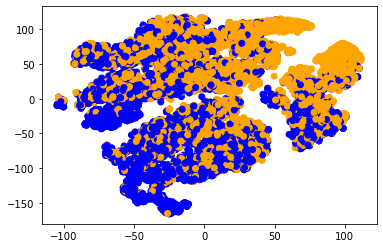

In [99]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c = np.where(train['label'] == 0, 'blue', 'orange').tolist())
plt.show()

In [100]:
B = test[to_select.values]
B = scaler.fit_transform(B)

tsne_test_data = TSNE(n_components = 2, random_state = 0, perplexity = 50, n_iter = 5000).fit_transform(B)
tsne_test_data 

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[  5.8684907, -47.586067 ],
       [-74.598045 ,  12.737642 ],
       [ 37.832573 ,  56.500065 ],
       ...,
       [-74.9724   ,  27.332695 ],
       [-96.66906  ,  35.087826 ],
       [ 20.62887  ,  83.78008  ]], dtype=float32)

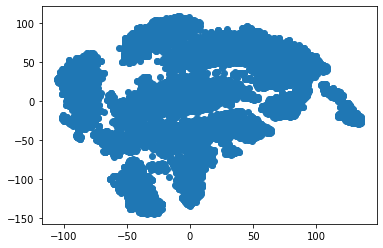

In [101]:
plt.scatter(tsne_test_data[:, 0], tsne_test_data[:, 1])
plt.show()

In [79]:
to_select = lasso_scores['Feature'][0:10]
to_select.values

array(['0.6564517315.csv', '0.7183933428.csv', '0.6570599977.csv',
       '0.6454375051.csv', '0.7103145610.csv', '0.6495843938.csv',
       '0.6802400070.csv', '0.7120881745.csv', '0.6708990553.csv',
       '0.6911116549.csv'], dtype=object)

In [81]:
X = train[to_select.values]
Y = train['label']

test_new = test[to_select.values]

## Defining list to store results
lgb_results = list()
test_preds_lgb_fold_1 = list() 
test_preds_lgb_fold_2 = list()
test_preds_lgb_fold_3 = list()
test_preds_lgb_fold_4 = list()
test_preds_lgb_fold_5 = list()

fold = 1
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
        
for train_ix, test_ix in kfold.split(X, Y):
    
    ## Splitting the data 
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

    ## Building model
    lgb_md = LGBMClassifier(n_estimators = 1000, 
                            learning_rate = 0.01,
                            num_leaves = 50,
                            max_depth = 17, 
                            lambda_l1 = 3, 
                            lambda_l2 = 1, 
                            bagging_fraction = 0.8, 
                            feature_fraction = 0.8).fit(X_train, Y_train)
        
    ## Predicting on test
    lgb_pred = lgb_md.predict_proba(X_test)[:, 1]
    score = log_loss(Y_test, lgb_pred)
    lgb_results.append(score)
        
    print('Fold ', str(fold), ' result is:', score, '\n')
    
    if (fold == 1):
        test_preds_lgb_fold_1.append(lgb_md.predict_proba(test_new)[:, 1])
        
    if (fold == 2):
        test_preds_lgb_fold_2.append(lgb_md.predict_proba(test_new)[:, 1])
        
    if (fold == 3):
        test_preds_lgb_fold_3.append(lgb_md.predict_proba(test_new)[:, 1])
        
    if (fold == 4):
        test_preds_lgb_fold_4.append(lgb_md.predict_proba(test_new)[:, 1])
        
    if (fold == 5):
        test_preds_lgb_fold_5.append(lgb_md.predict_proba(test_new)[:, 1])
    
    fold +=1

print('The average log-loss over 5-fold CV is', np.mean(lgb_results))

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Fold  1  result is: 0.5365948807953819 

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Fold  2  result is: 0.5249645823821217 

[LightGBM] [Warning] lambda_l1 is set=

In [70]:
w1 = 1/ lgb_results[0]
w2 = 1/ lgb_results[1]
w3 = 1/ lgb_results[2]
w4 = 1/ lgb_results[3]
w5 = 1/ lgb_results[4]
w_tot = w1 + w2 + w3+ w4 + w5
w1 = w1 / w_tot
w2 = w2 / w_tot
w3 = w3 / w_tot
w4 = w4 / w_tot
w5 = w5 / w_tot

In [71]:
pred1 = w1*test_preds_lgb_fold_1[0]
pred2 = w2*test_preds_lgb_fold_2[0]
pred3 = w3*test_preds_lgb_fold_3[0]
pred4 = w4*test_preds_lgb_fold_4[0]
pred5 = w4*test_preds_lgb_fold_5[0]

In [72]:
w1 + w2 + w3 + w4 + w5

1.0000000000000002

In [20]:
# test_preds_lgb = pd.DataFrame(test_preds_lgb)
# print(test_preds_lgb.shape)

# test_preds_lgb = test_preds_lgb.mean(axis = 0)
# print(test_preds_lgb.head(5))

(5, 20000)
0    0.488396
1    0.622083
2    0.195511
3    0.534368
4    0.032400
dtype: float64


In [73]:
submission['pred'] = pred1 + pred2 + pred3 + pred4 + pred5
submission.head()

,id,pred
0,20000,0.446554
1,20001,0.622839
2,20002,0.197050
3,20003,0.522044
4,20004,0.054001


In [74]:
submission.to_csv('submission_logit_lasso_50_weight_0.2.csv', index = False)